# Homework 5: Ergodic Control
Due: May 30, 2025

## Preliminaries

[iLQR Template from Murphey Lab](https://github.com/MurpheyLab/ergodic-control-sandbox/tree/main#)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [78]:
class iLQR_template:
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v) -> None:
        self.dt = dt
        self.tsteps = tsteps

        self.x_dim = x_dim
        self.u_dim = u_dim

        self.Q_z = Q_z
        self.Q_z_inv = np.linalg.inv(Q_z)
        self.R_v = R_v
        self.R_v_inv = np.linalg.inv(R_v)

        self.curr_x_traj = None
        self.curr_y_traj = None

    def dyn(self, xt, ut):
        raise NotImplementedError("Not implemented.")

    def step(self, xt, ut):
        """RK4 integration"""
        k1 = self.dt * self.dyn(xt, ut)
        k2 = self.dt * self.dyn(xt + k1/2.0, ut)
        k3 = self.dt * self.dyn(xt + k2/2.0, ut)
        k4 = self.dt * self.dyn(xt + k3, ut)

        xt_new = xt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
        return xt_new

    def traj_sim(self, x0, u_traj):
        x_traj = np.zeros((self.tsteps, self.x_dim))
        xt = x0.copy()
        for t_idx in range(self.tsteps):
            xt = self.step(xt, u_traj[t_idx])
            x_traj[t_idx] = xt.copy()
        return x_traj

    def loss(self):
        raise NotImplementedError("Not implemented.")

    def get_At_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")

    def get_Bt_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")

    def get_at_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")

    def get_bt_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")

    # the following functions are utilities for solving the Riccati equation
    def P_dyn_rev(self, Pt, At, Bt, at, bt):
        return Pt @ At + At.T @ Pt - Pt @ Bt @ self.R_v_inv @ Bt.T @ Pt + self.Q_z

    def P_dyn_step(self, Pt, At, Bt, at, bt):
        k1 = self.dt * self.P_dyn_rev(Pt, At, Bt, at, bt)
        k2 = self.dt * self.P_dyn_rev(Pt+k1/2, At, Bt, at, bt)
        k3 = self.dt * self.P_dyn_rev(Pt+k2/2, At, Bt, at, bt)
        k4 = self.dt * self.P_dyn_rev(Pt+k3, At, Bt, at, bt)

        Pt_new = Pt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
        return Pt_new

    def P_traj_revsim(self, PT, A_traj, B_traj, a_traj, b_traj):
        P_traj_rev = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        P_curr = PT.copy()
        for t in range(self.tsteps):
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            P_new = self.P_dyn_step(P_curr, At, Bt, at, bt)
            P_traj_rev[t] = P_new.copy()
            P_curr = P_new

        return P_traj_rev

    def r_dyn_rev(self, rt, Pt, At, Bt, at, bt):
        return (At - Bt @ self.R_v_inv @ Bt.T @ Pt).T @ rt + at - Pt @ Bt @ self.R_v_inv @ bt

    def r_dyn_step(self, rt, Pt, At, Bt, at, bt):
        k1 = self.dt * self.r_dyn_rev(rt, Pt, At, Bt, at, bt)
        k2 = self.dt * self.r_dyn_rev(rt+k1/2, Pt, At, Bt, at, bt)
        k3 = self.dt * self.r_dyn_rev(rt+k2/2, Pt, At, Bt, at, bt)
        k4 = self.dt * self.r_dyn_rev(rt+k3, Pt, At, Bt, at, bt)

        rt_new = rt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
        return rt_new

    def r_traj_revsim(self, rT, P_traj, A_traj, B_traj, a_traj, b_traj):
        r_traj_rev = np.zeros((self.tsteps, self.x_dim))
        r_curr = rT
        for t in range(self.tsteps):
            Pt = P_traj[-1-t]
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            r_new = self.r_dyn_step(r_curr, Pt, At, Bt, at, bt)
            r_traj_rev[t] = r_new.copy()
            r_curr = r_new

        return r_traj_rev

    def z_dyn(self, zt, Pt, rt, At, Bt, bt):
        return At @ zt + Bt @ self.z2v(zt, Pt, rt, Bt, bt)

    def z_dyn_step(self, zt, Pt, rt, At, Bt, bt):
        k1 = self.dt * self.z_dyn(zt, Pt, rt, At, Bt, bt)
        k2 = self.dt * self.z_dyn(zt+k1/2, Pt, rt, At, Bt, bt)
        k3 = self.dt * self.z_dyn(zt+k2/2, Pt, rt, At, Bt, bt)
        k4 = self.dt * self.z_dyn(zt+k3, Pt, rt, At, Bt, bt)

        zt_new = zt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
        return zt_new

    def z_traj_sim(self, z0, P_traj, r_traj, A_traj, B_traj, b_traj):
        z_traj = np.zeros((self.tsteps, self.x_dim))
        z_curr = z0.copy()

        for t in range(self.tsteps):
            Pt = P_traj[t]
            rt = r_traj[t]
            At = A_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]

            z_new = self.z_dyn_step(z_curr, Pt, rt, At, Bt, bt)
            z_traj[t] = z_new.copy()
            z_curr = z_new

        return z_traj

    def z2v(self, zt, Pt, rt, Bt, bt):
        return -self.R_v_inv @ Bt.T @ Pt @ zt - self.R_v_inv @ Bt.T @ rt - self.R_v_inv @ bt

    def get_descent(self, x0, u_traj):
        # forward simulate the trajectory
        x_traj = self.traj_sim(x0, u_traj)
        self.curr_x_traj = x_traj.copy()
        self.curr_u_traj = u_traj.copy()

        # sovle the Riccati equation backward in time
        A_traj = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        B_traj = np.zeros((self.tsteps, self.x_dim, self.u_dim))
        a_traj = np.zeros((self.tsteps, self.x_dim))
        b_traj = np.zeros((self.tsteps, self.u_dim))

        for t_idx in range(self.tsteps):
            A_traj[t_idx] = self.get_At_mat(t_idx)
            B_traj[t_idx] = self.get_Bt_mat(t_idx)
            a_traj[t_idx] = self.get_at_vec(t_idx)
            b_traj[t_idx] = self.get_bt_vec(t_idx)

        # print('a_traj:\n', a_traj)

        PT = np.zeros((self.x_dim, self.x_dim))
        P_traj_rev = self.P_traj_revsim(PT, A_traj, B_traj, a_traj, b_traj)
        P_traj = np.flip(P_traj_rev, axis=0)

        rT = np.zeros(self.x_dim)
        r_traj_rev = self.r_traj_revsim(
            rT, P_traj, A_traj, B_traj, a_traj, b_traj)
        r_traj = np.flip(r_traj_rev, axis=0)

        z0 = np.zeros(self.x_dim)
        z_traj = self.z_traj_sim(z0, P_traj, r_traj, A_traj, B_traj, b_traj)

        # compute the descent direction
        v_traj = np.zeros((self.tsteps, self.u_dim))
        for t in range(self.tsteps):
            zt = z_traj[t]
            Pt = P_traj[t]
            rt = r_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]
            v_traj[t] = self.z2v(zt, Pt, rt, Bt, bt)

        return v_traj
    

class GaussianDistribution:
    def __init__(self, omega, mu, sigma):
        self.omega = omega
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        # x: shape (N, 2)
        d = x - self.mu  # shape (N, 2)
        inv_sigma = np.linalg.inv(self.sigma)
        exponent = np.einsum('ni,ij,nj->n', d, inv_sigma, d)
        norm_const = np.sqrt(np.linalg.det(2 * np.pi * self.sigma))
        return self.omega * np.exp(-0.5 * exponent) / norm_const


G1 = GaussianDistribution(
    omega=0.5, mu=np.array([0.35, 0.38]).T,
    sigma=np.array([[0.01, 0.004], [0.004, 0.01]])
)
G2 = GaussianDistribution(
    omega=0.2, mu=np.array([0.68, 0.25]).T,
    sigma=np.array([[0.005, -0.003], [-0.003, 0.005]])
)
G3 = GaussianDistribution(
    omega=0.3, mu=np.array([0.56, 0.64]).T,
    sigma=np.array([[0.008, 0], [0, 0.004]])
)


def combined_distribution(x):
    return G1.pdf(x) + G2.pdf(x) + G3.pdf(x)


def run_ergodic(controller, x0, U_init, n_iters=100, alpha=0.5, step0=0.002, name=''):
    U_traj = U_init.copy()
    loss_history = []
    for _ in tqdm(range(n_iters), desc=f'{name} Ergodic Control'):
        x_traj = controller.traj_sim(x0, U_traj)
        v_traj = controller.get_descent(x0, U_traj)
        loss_val = controller.loss(x_traj, U_traj)
        loss_history.append(loss_val)
        # Armijo line search
        step = step0
        for _ in range(n_iters // 10):
            U_new = U_traj + step * v_traj
            loss_new = controller.loss(controller.traj_sim(x0, U_new), U_new)
            if loss_new < loss_val:
                break
            step *= alpha
        U_traj += step * v_traj
    return controller.traj_sim(x0, U_traj), U_traj, np.array(loss_history)


def plot_controller_results(X_traj, U_traj, cost_history, x0, grids, grids_x, grids_y, combined_distribution, name):
    # Combined figure with three subplots: (1) Gaussian distributions & trajectory, (2) Control Inputs, (3) Cost History
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    # Plot 1: Gaussian distributions and trajectory
    contour = ax1.contourf(grids_x, grids_y, combined_distribution(grids).reshape(grids_x.shape),
                           levels=6, alpha=1.0, cmap='viridis')
    ax1.scatter(x0[0], x0[1], color='blue', label='Initial Condition')
    ax1.plot(X_traj[:, 0], X_traj[:, 1], color='red',
             linewidth=2, label='Ergodic Trajectory')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.set_aspect('equal')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Gaussian Mixture & Ergodic Trajectory')
    ax1.legend(loc='upper right')

    # Plot 2: Control inputs [U] over time
    ax2.plot(np.arange(100), U_traj[:, 0],
             label=r'$u_1(t)$', color='blue')
    ax2.plot(np.arange(100), U_traj[:, 1],
             label=r'$u_2(t)$', color='green')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Control Input')
    ax2.set_title('Control Inputs Over Time')
    ax2.legend(loc='upper right')

    # Plot 3: Cost history
    ax3.plot(np.arange(len(cost_history)), cost_history,
             marker='o', color='orange', label='Cost History')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Cost')
    ax3.set_title('Cost History')
    ax3.legend(loc='upper right')

    plt.tight_layout()
    plt.suptitle(f'{name} Ergodic Control Results', fontsize=16)
    plt.subplots_adjust(top=0.85)  # Adjust title position
    filename = f'{str.lower(name).replace(" ", "_")}_results.png'
    plt.savefig(filename)
    # plt.show()

In [79]:
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99

# Configure the index vectors
num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T

# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
hk_list = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk

# compute the coefficients for the target distribution
phik_list = np.zeros(ks.shape[0])
pdf_vals = combined_distribution(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    fk_vals /= hk

    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik

# Define the optimal control problem
dt = 0.1
tsteps = 100
R = np.diag([0.0001, 0.0001])
Q_z = np.diag([0.01, 0.01])
Q_z_double = np.diag([0.01, 0.01, 0.00001, 0.00001])  # For double integrator
Q_z_diff_drive = np.diag([0.01, 0.01, 0.00001])  # For differential drive
R_v = np.diag([0.01, 0.01])
x0 = np.array([0.3, 0.3])  # Initial condition
x0_double = np.array([0.3, 0.3, 0.0, 0.0])  # For double integrator
x0_diff_drive = np.array([0.3, 0.3, np.pi / 2])  # For differential drive

# generate a spiral trajectory as the initial control
temp_x_traj = np.array([
    np.linspace(0.0, 0.3, tsteps+1) *
    np.cos(np.linspace(0.0, 2*np.pi, tsteps+1)),
    np.linspace(0.0, 0.3, tsteps+1) *
    np.sin(np.linspace(0.0, 2*np.pi, tsteps+1))
]).T

# Generate initial control trajectory
# 1) Point-mass: u = velocity
vel = np.diff(temp_x_traj, axis=0) / dt
vel_pad = np.vstack((vel, vel[-1]))  # pad to length tsteps+1 if needed

init_u_traj = vel  # shape (tsteps, 2)
print(f"Initial control trajectory shape: {init_u_traj.shape}")

# 2) Double integrator: u = acceleration
acc = np.diff(vel_pad, axis=0) / dt
init_u_traj_double = acc[:tsteps]  # ensure shape is (tsteps, 2)
print(f"Initial control trajectory for double integrator shape: {init_u_traj_double.shape}")

# 3) Differential drive: u = [v, omega]
v = np.linalg.norm(vel_pad, axis=1)
theta = np.arctan2(vel_pad[:, 1], vel_pad[:, 0])
omega = np.diff(theta) / dt
omega = np.hstack((omega, omega[-1]))  # pad to length tsteps+1
init_u_traj_diff = np.vstack((v[:tsteps], omega[:tsteps])).T  # shape (tsteps, 2)
print(f"Initial control trajectory for differential drive shape: {init_u_traj_diff.shape}")

Initial control trajectory shape: (100, 2)
Initial control trajectory for double integrator shape: (100, 2)
Initial control trajectory for differential drive shape: (100, 2)




# Problem 1: Ergodic Control of a Gaussian Mixture Distribution
We have a $1\times 1$ search space [meters] and the target spatial distribution as a Gaussian mixture distribution specified as follows:

| Component | Weight $(\omega)$ | Mean $(\mu)$                | Covariance $(\Sigma)$                                                                 |
|-----------|------------------|-----------------------------|---------------------------------------------------------------------------------------|
| 1         | 0.5              | $[0.35,\ 0.38]^T$           | $\begin{bmatrix} 0.01 & 0.004 \\ 0.004 & 0.01 \end{bmatrix}$                          |
| 2         | 0.2              | $[0.68,\ 0.25]^T$           | $\begin{bmatrix} 0.005 & -0.003 \\ -0.003 & 0.005 \end{bmatrix}$                      |
| 3         | 0.3              | $[0.56,\ 0.64]^T$           | $\begin{bmatrix} 0.008 & 0 \\ 0 & 0.004 \end{bmatrix}$                                |

The system is a 2D first-order dynamic system:

$$
\dot{x}(t) = f(x(t), u(t)) = u(t)
$$

with the initial condition $x_0 = [0.3, 0.3]$. Generate an ergodic trajectory with a time horizon of 10 seconds with $\Delta t$ = 0.1s

In [80]:
class iLQR_ergodic_pointmass(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, ks, L_list, lamk_list, hk_list, phik_list) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)

        self.R = R
        self.ks = ks
        self.L_list = L_list
        self.lamk_list = lamk_list
        self.hk_list = hk_list
        self.phik_list = phik_list

    def dyn(self, xt, ut):
        return ut

    def get_At_mat(self, t_idx):
        A = np.zeros((self.x_dim, self.x_dim))
        return A

    def get_Bt_mat(self, t_idx):
        B = np.eye(self.u_dim)
        return B

    def get_at_vec(self, t_idx):
        xt = self.curr_x_traj[t_idx][:2]
        x_traj = self.curr_x_traj[:, :2]

        dfk_xt_all = np.array([
            -np.pi * self.ks[:, 0] / self.L_list[0] * np.sin(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.cos(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
            -np.pi * self.ks[:, 1] / self.L_list[1] * np.cos(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.sin(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
        ]) / self.hk_list

        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
                         x_traj[:, None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)

        at = np.sum(self.lamk_list * 2.0 * (ck_all - self.phik_list)
                    * dfk_xt_all / (self.tsteps * self.dt), axis=1)
        return at

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut

    def loss(self, x_traj, u_traj):
        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
                         x_traj[:, None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)
        erg_metric = np.sum(
            self.lamk_list * np.square(ck_all - self.phik_list))

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt
        return erg_metric + ctrl_cost

First Order Ergodic Control:   0%|          | 0/100 [00:00<?, ?it/s]

First Order Ergodic Control: 100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


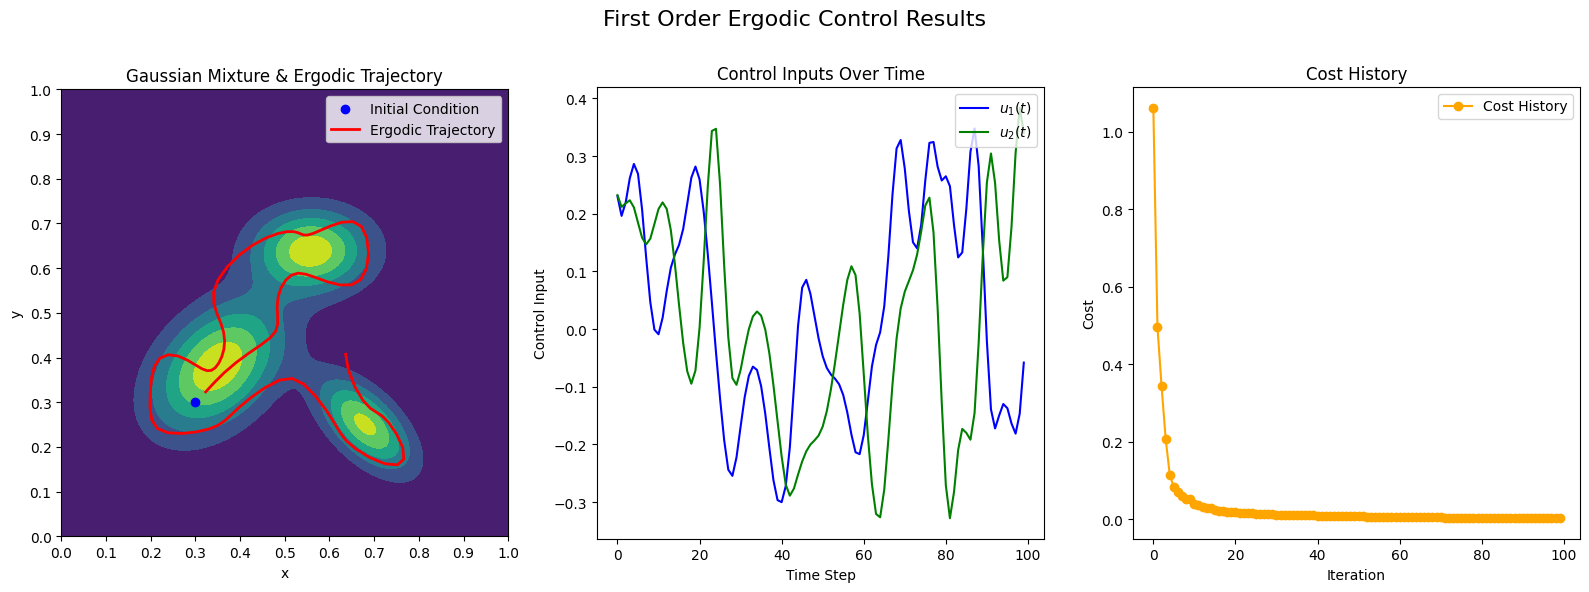

In [81]:
trajopt_ergodic_pointmass = iLQR_ergodic_pointmass(
    dt, tsteps, x_dim=2, u_dim=2, Q_z=Q_z, R_v=R_v,
    R=R, ks=ks, L_list=L_list, lamk_list=lamk_list,
    hk_list=hk_list, phik_list=phik_list
)
# Run the ergodic control for point mass
X_traj, U_traj, cost_history = run_ergodic(
    trajopt_ergodic_pointmass, x0, init_u_traj,
    n_iters=100, alpha=0.5, step0=0.002, name='First Order'
)
plot_controller_results(
    X_traj, U_traj, cost_history, x0,
    grids, grids_x, grids_y, combined_distribution,
    name='First Order'
)


# Problem 2: Second Order System Dynamics

In [82]:
class iLQR_ergodic_double_integrator(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, ks, L_list, lamk_list, hk_list, phik_list) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)

        self.R = R
        self.ks = ks
        self.L_list = L_list
        self.lamk_list = lamk_list
        self.hk_list = hk_list
        self.phik_list = phik_list

    def dyn(self, xt, ut):
        # x_ddot(t) = u(t)
        # xt = [x(t), y(t), x_dot(t), y_dot(t)]
        # ut = [u_x(t), u_y(t)]
        return np.array([xt[2], xt[3], ut[0], ut[1]])

    def get_At_mat(self, t_idx):
        A = np.zeros((self.x_dim, self.x_dim))
        A[0:2, 2:4] = np.eye(2)
        return A

    def get_Bt_mat(self, t_idx):
        B = np.zeros((self.x_dim, self.u_dim))
        B[2:4, :] = np.eye(2)
        return B

    def get_at_vec(self, t_idx):
        xt = self.curr_x_traj[t_idx][:2]
        x_traj = self.curr_x_traj[:, :2]

        dfk_xt_all = np.array([
            -np.pi * self.ks[:, 0] / self.L_list[0] * np.sin(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.cos(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
            -np.pi * self.ks[:, 1] / self.L_list[1] * np.cos(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.sin(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
        ]) / self.hk_list

        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
                         x_traj[:, None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)

        at = np.sum(self.lamk_list * 2.0 * (ck_all - self.phik_list)
                    * dfk_xt_all / (self.tsteps * self.dt), axis=1)
        # return at
        return np.hstack((at, np.zeros(self.x_dim - 2)))

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut

    def loss(self, x_traj, u_traj):
        x_pos = x_traj[:, :2]
        # fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
        #                  x_traj[:, None]), axis=2) / self.hk_list
        fk_all = np.prod(
            np.cos(np.pi * self.ks / self.L_list * x_pos[:, None]),
            axis=2
        ) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)
        erg_metric = np.sum(
            self.lamk_list * np.square(ck_all - self.phik_list))

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt
        return erg_metric + ctrl_cost

Second Order Ergodic Control: 100%|██████████| 100/100 [00:02<00:00, 36.04it/s]


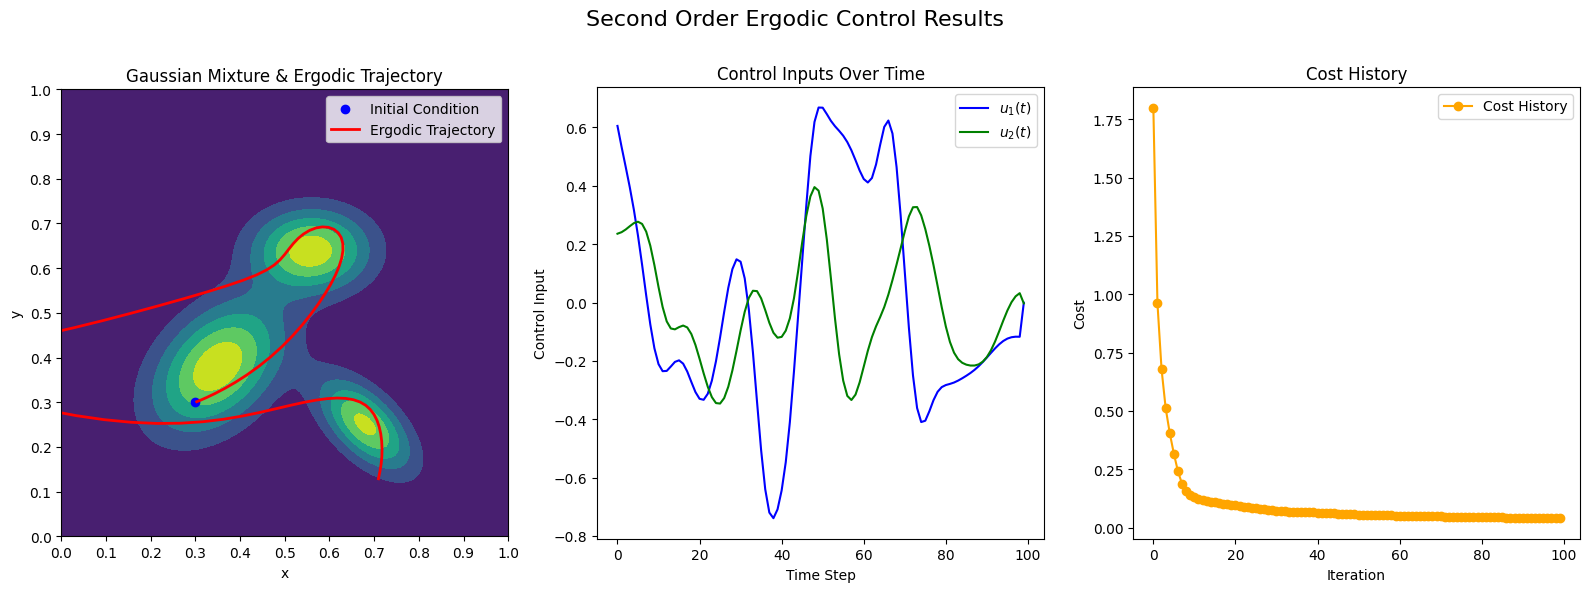

In [83]:
trajopt_ergodic_double_integrator = iLQR_ergodic_double_integrator(
    dt, tsteps, x_dim=4, u_dim=2, Q_z=Q_z_double, R_v=R_v,
    R=R, ks=ks, L_list=L_list, lamk_list=lamk_list,
    hk_list=hk_list, phik_list=phik_list
)
# Run the ergodic control for double integrator
X_traj, U_traj, cost_history = run_ergodic(
    trajopt_ergodic_double_integrator, x0_double, init_u_traj_double,
    n_iters=100, alpha=0.5, step0=0.002, name='Second Order'
)
plot_controller_results(
    X_traj, U_traj, cost_history, x0_double,
    grids, grids_x, grids_y, combined_distribution,
    name='Second Order'
)

# Problem 3: Differential-Drive System

In [84]:
class iLQR_ergodic_diff_drive(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, ks, L_list, lamk_list, hk_list, phik_list) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)

        self.R = R
        self.ks = ks
        self.L_list = L_list
        self.lamk_list = lamk_list
        self.hk_list = hk_list
        self.phik_list = phik_list

    def dyn(self, xt, ut):
        v, omega = ut
        theta = xt[2]
        return np.array([
            v * np.cos(theta),
            v * np.sin(theta),
            omega
        ])

    def get_At_mat(self, t_idx):
        A = np.zeros((self.x_dim, self.x_dim))
        v = self.curr_u_traj[t_idx][0]
        theta = self.curr_x_traj[t_idx][2]
        A[0, 2] = -v * np.sin(theta)
        A[1, 2] = v * np.cos(theta)
        return A

    def get_Bt_mat(self, t_idx):
        # B = np.eye(self.u_dim)
        B = np.zeros((self.x_dim, self.u_dim))
        theta = self.curr_x_traj[t_idx][2]
        B[0, 0] = np.cos(theta)
        B[1, 0] = np.sin(theta)
        B[2, 1] = 1.0
        return B

    def get_at_vec(self, t_idx):
        xt = self.curr_x_traj[t_idx][:2]
        x_traj = self.curr_x_traj[:, :2]

        dfk_xt_all = np.array([
            -np.pi * self.ks[:, 0] / self.L_list[0] * np.sin(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.cos(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
            -np.pi * self.ks[:, 1] / self.L_list[1] * np.cos(np.pi * self.ks[:, 0] / self.L_list[0] * xt[0]) * np.sin(
                np.pi * self.ks[:, 1] / self.L_list[1] * xt[1]),
        ]) / self.hk_list

        fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
                         x_traj[:, None]), axis=2) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)

        at = np.sum(self.lamk_list * 2.0 * (ck_all - self.phik_list)
                    * dfk_xt_all / (self.tsteps * self.dt), axis=1)
        return np.hstack((at, np.zeros(self.x_dim - 2)))

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut

    def loss(self, x_traj, u_traj):
        x_pos = x_traj[:, :2]
        # fk_all = np.prod(np.cos(np.pi * self.ks / self.L_list *
        #                  x_traj[:, None]), axis=2) / self.hk_list
        fk_all = np.prod(
            np.cos(np.pi * self.ks / self.L_list * x_pos[:, None]), axis=2
        ) / self.hk_list
        ck_all = np.sum(fk_all, axis=0) * self.dt / (self.tsteps * self.dt)
        erg_metric = np.sum(
            self.lamk_list * np.square(ck_all - self.phik_list))

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt
        return erg_metric + ctrl_cost

Differential Drive Ergodic Control: 100%|██████████| 100/100 [00:02<00:00, 34.29it/s]


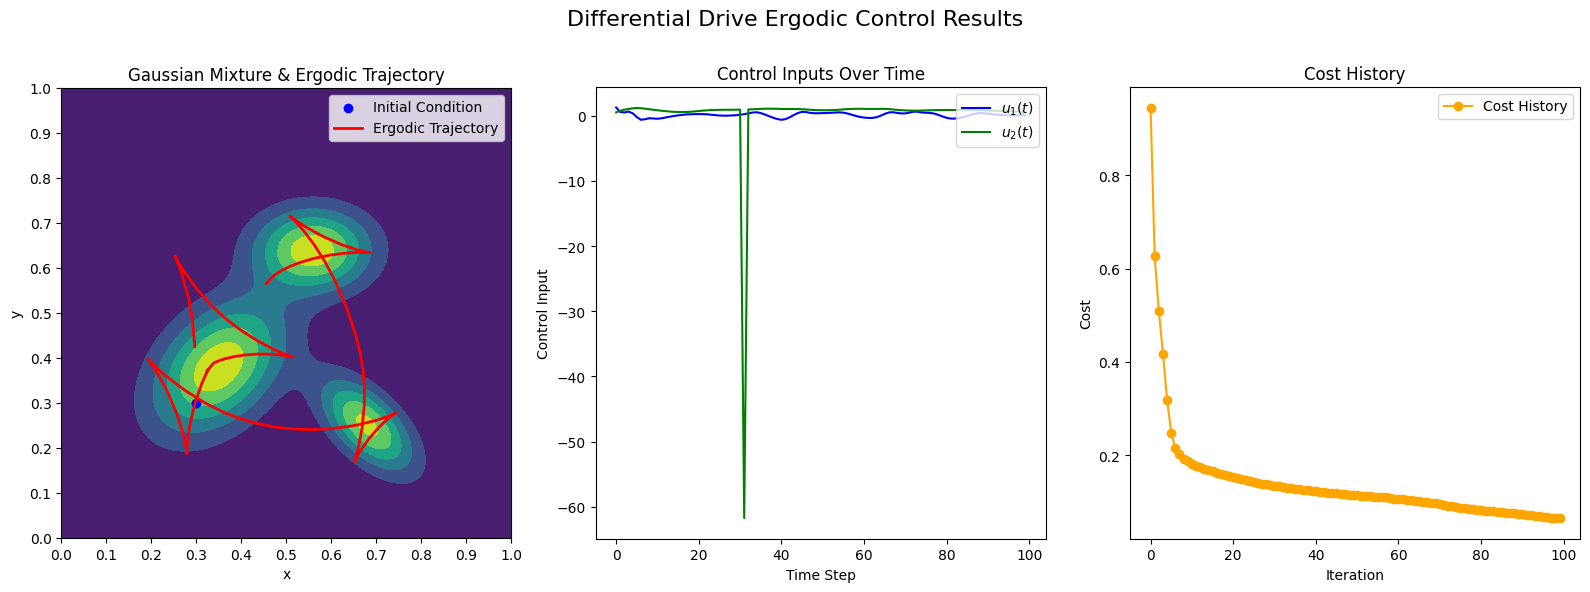

In [85]:
trajopt_ergodic_diff_drive = iLQR_ergodic_diff_drive(
    dt, tsteps, x_dim=3, u_dim=2, Q_z=Q_z_diff_drive, R_v=R_v,
    R=R, ks=ks, L_list=L_list, lamk_list=lamk_list,
    hk_list=hk_list, phik_list=phik_list
)
# Run the ergodic control for differential drive
X_traj, U_traj, cost_history = run_ergodic(
    trajopt_ergodic_diff_drive, x0_diff_drive, init_u_traj_diff,
    n_iters=100, alpha=0.5, step0=0.002, name='Differential Drive'
)
plot_controller_results(
    X_traj, U_traj, cost_history, x0_diff_drive,
    grids, grids_x, grids_y, combined_distribution,
    name='Differential Drive'
)

# Results

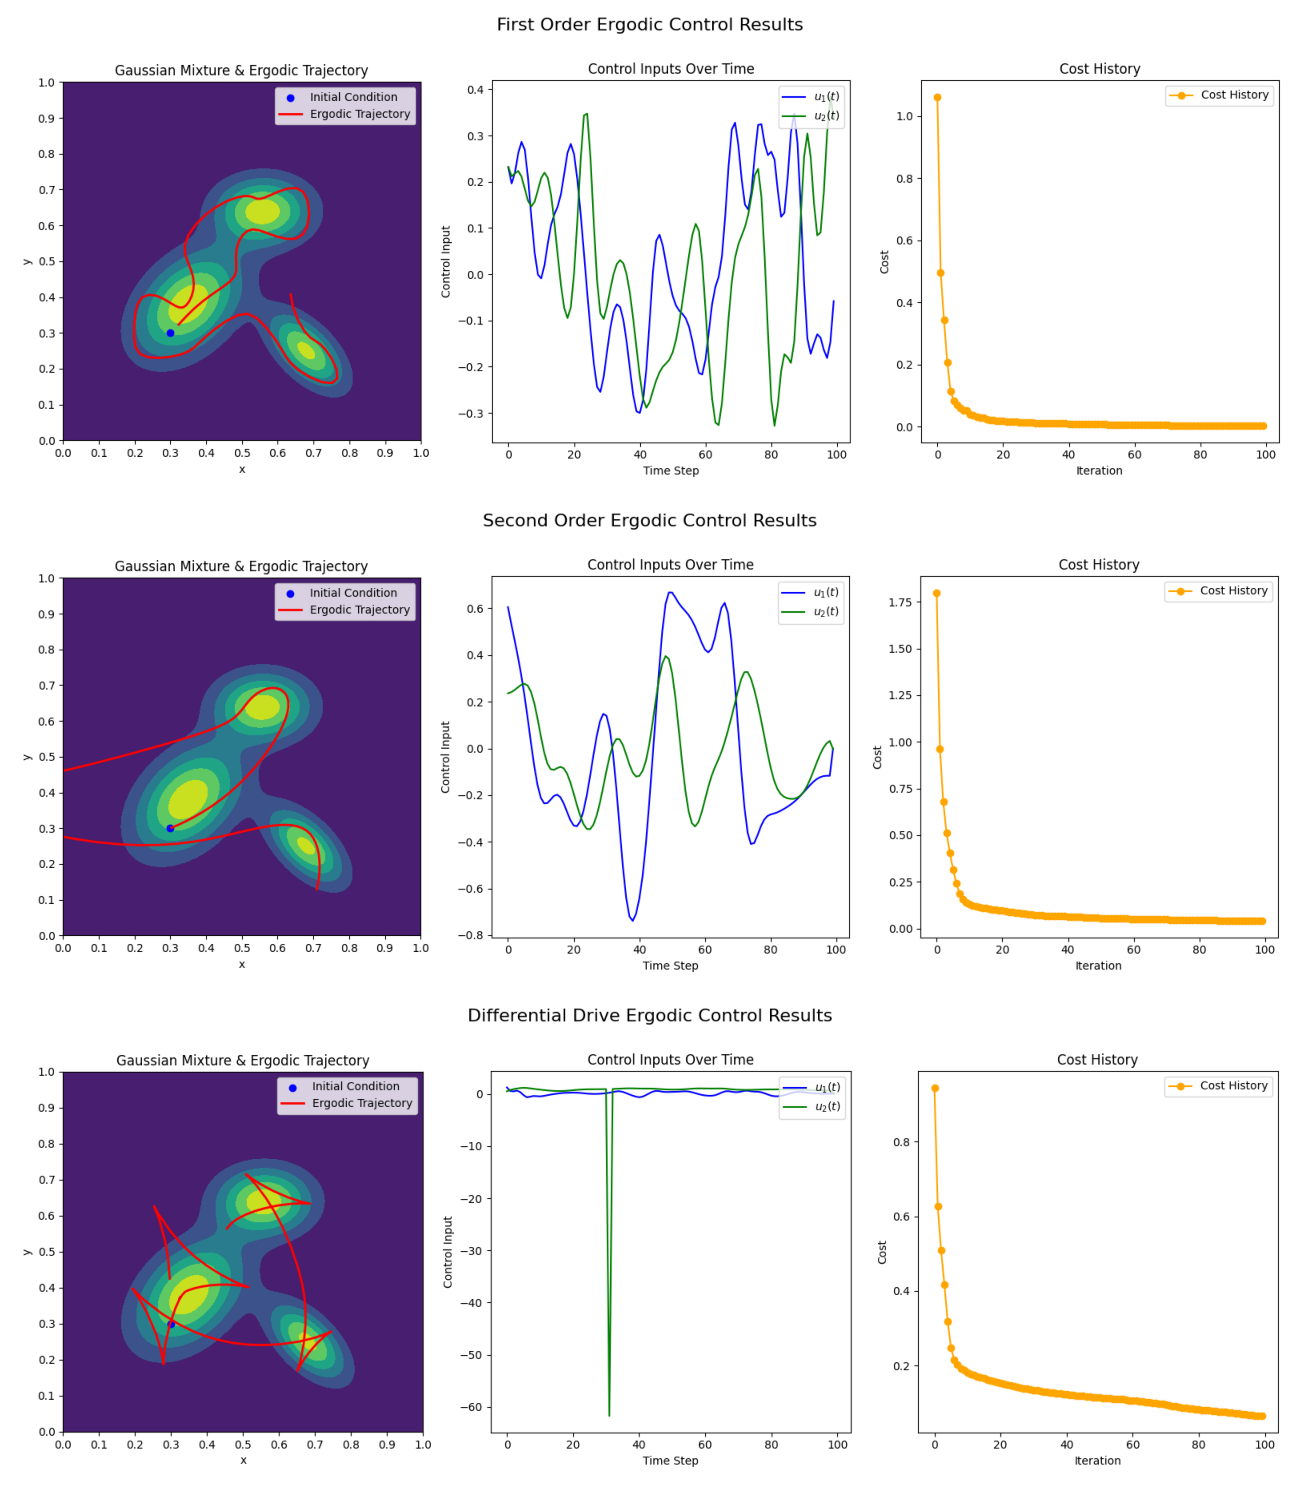

In [86]:
def combine_all_plots():
    # 1) Find and sort all your iLQR result files
    files = sorted(glob.glob('*_results.png'))

    # 2) Read them in
    # images = [plt.imread(f) for f in files]
    images = [plt.imread(f) for f in sorted(files)]
    # diff_drive, first_order, second_order
    # Move around so it's first order, second order, diff drive
    # Reorder to first, second, diff drive
    images = [images[1], images[2], images[0]]
    # 3) Create a figure with one row per image
    n = len(images)
    fig, axes = plt.subplots(n, 1, figsize=(15, 5*n))

    for ax, img, fname in zip(axes, images, files):
        ax.imshow(img)
        # ax.set_title(os.path.basename(fname), fontsize=12)
        ax.axis('off')

    # plt.suptitle('All Ergodic Control Reults', fontsize=14, y=0.92)
    plt.tight_layout()
    # plt.subplots_adjust(top=0.95)  # make room for the suptitle
    fig.savefig('ergodic_control.png', dpi=150)

combine_all_plots()

In [87]:
# Convert the combined plot to PDF
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('ergodic_control.pdf') as pdf:
    combine_all_plots()
    pdf.savefig()  # Save the current figure into a pdf page
    plt.close()  # Close the figure to free memory